In [15]:
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os, shutil
import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras import models
from keras import layers
from sklearn.utils import class_weight

In [16]:
import tensorflow_addons as tfa




# Lets Try a Popular Neural Network: ResNet

In [17]:
# Create a data generator
datagen2 = ImageDataGenerator(
    rescale=1./255, # normalize pixel values
    rotation_range=45, # randomly rotate images in the range
    zoom_range=0.35, # randomly zoom image 
    width_shift_range=0.35, # randomly shift images horizontally
    height_shift_range=0.35, # randomly shift images vertically 
    horizontal_flip=True,
    vertical_flip=True) # randomly flip images

In [32]:
# Use flow_from_directory to read images from folders
train_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/train', # point to the parent directory
        target_size=(299, 299), # resize images to 299x299
        batch_size=32,
        class_mode='binary') # binary for two classes

# Similarly create validation and test generators
val_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/val',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

test_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary',
        shuffle=False)


Found 4098 images belonging to 2 classes.
Found 879 images belonging to 2 classes.
Found 879 images belonging to 2 classes.


In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Define new top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Adding a GlobalAveragePooling2D layer to reduce the feature maps
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Define the new model
model2 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


94765736/94765736 [==============================] - 6s 0us/step


In [23]:
from collections import Counter

counter = Counter(train_generator2.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

print(counter)
print(max_val)
print(class_weights)

Counter({1: 2991, 0: 1107})
2991.0
{0: 2.7018970189701896, 1: 1.0}


In [25]:
epochs = 30

steps_per_epoch2 = np.ceil(train_generator2.samples / train_generator2.batch_size)
validation_steps2 = np.ceil(val_generator2.samples / val_generator2.batch_size)

history = model2.fit(
    train_generator2,
    steps_per_epoch=int(steps_per_epoch2),
    epochs=epochs,
    validation_data=val_generator2,
    validation_steps=int(validation_steps2),
    class_weight=class_weights)



Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 0.5610 - acc: 0.8402

2023-07-13 13:36:16.576784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 108s 823ms/step - loss: 0.5610 - acc: 0.8402 - val_loss: 8.2341 - val_acc: 0.7301
Epoch 2/30
129/129 [==============================] - 107s 821ms/step - loss: 0.4893 - acc: 0.8504 - val_loss: 3.1578 - val_acc: 0.7301
Epoch 3/30
129/129 [==============================] - 112s 860ms/step - loss: 0.4683 - acc: 0.8592 - val_loss: 0.6020 - val_acc: 0.7301
Epoch 4/30
129/129 [==============================] - 106s 820ms/step - loss: 0.3978 - acc: 0.8821 - val_loss: 2.7443 - val_acc: 0.7301
Epoch 5/30
129/129 [==============================] - 109s 839ms/step - loss: 0.3842 - acc: 0.8838 - val_loss: 1.7629 - val_acc: 0.7301
Epoch 6/30
129/129 [==============================] - 107s 828ms/step - loss: 0.3846 - acc: 0.8812 - val_loss: 0.4544 - val_acc: 0.8018
Epoch 7/30
129/129 [==============================] - 110s 850ms/step - loss: 0.3788 - acc: 0.8846 - val_loss: 0.8524 - val_acc: 0.7494
Epoch 8/30
129/129 [==============================] - 109s 

In [26]:
results_train = model2.evaluate(train_generator2)
results_test = model2.evaluate(val_generator2)
print('Training set performance:', results_train)
print('Validation set performance:', results_test)

28/28 [==============================] - 13s 457ms/step - loss: 0.2746 - acc: 0.9055
Training set performance: [0.2640553414821625, 0.9006832838058472]
Validation set performance: [0.2745646834373474, 0.9054670333862305]


In [27]:
model2.save('modelResNet.h5')  # creates a HDF5 file 'my_model.h5'

In [33]:
y_pred = model2.predict(test_generator2)

28/28 [==============================] - 13s 433ms/step


In [34]:
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator2.classes

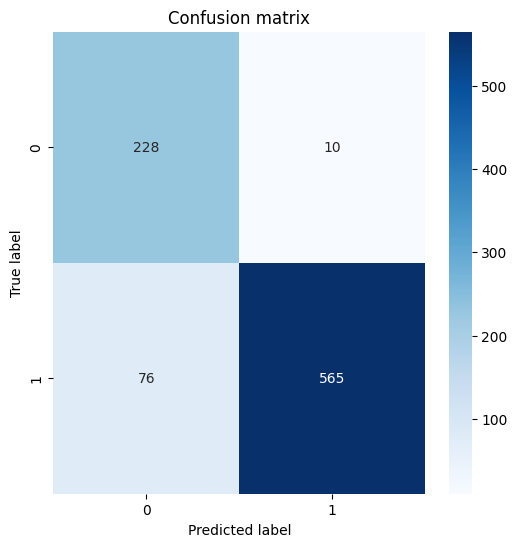

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# results are not as good as my model
# here we have a lot of false negatives, which is a lot worse than a false positive in terms of a pneumonia diagnosis

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [36]:
from sklearn.metrics import classification_report



print(classification_report(y_true, y_pred, target_names=test_generator2.class_indices.keys()))


              precision    recall  f1-score   support

      NORMAL       0.75      0.96      0.84       238
   PNEUMONIA       0.98      0.88      0.93       641

    accuracy                           0.90       879
   macro avg       0.87      0.92      0.89       879
weighted avg       0.92      0.90      0.91       879



28/28 [==============================] - 13s 429ms/step
AUC:  0.9742261959385939


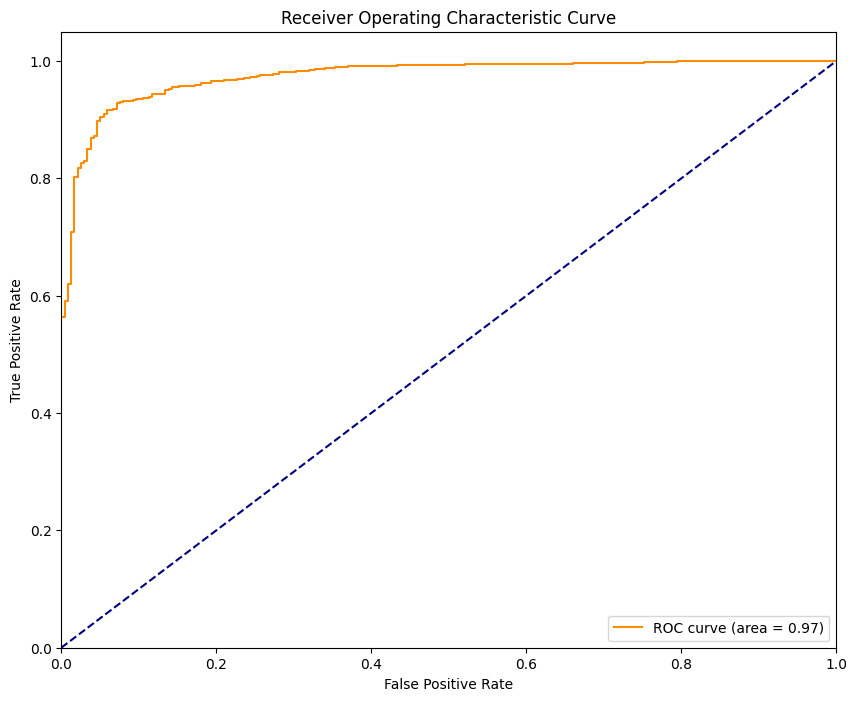

In [38]:
#ROCAUC not as good as my best model

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming val_generator2 is your validation generator
test_generator2.reset()

# Generate predictions
y_pred_probs = model2.predict(test_generator2)

# Get true labels
y_true = test_generator2.classes

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs)
print("AUC: ", auc)
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
